### Simple GAN

- We will have two neural network:
  - Discriminative model
  - Generative model

1. Discriminative model will be fed `real & fake (generated) images` and it has to detect which one is real & fake.
2. Generative model's aim is to generate new image and fool Discriminative model into thinking that the new image generated is real image.

These models compete and learn to improve over time.

- One thing to keep in mind is, both model should start training from very little. If one model is superior to other, it will leave very little scope for the other model to learn and train.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard


In [2]:
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import v2
from torch.utils.tensorboard import SummaryWriter  # to print to tensorboard


### `Discriminator`, will be used by Discriminative to classify if the generated image is real or fake.

In [3]:
class Discriminator(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.disc = nn.Sequential(
            nn.Linear(in_features, 128),
            nn.LeakyReLU(0.01),
            nn.Linear(128, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.disc(x)

### `Generator`, will be generating images

In [4]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        super().__init__()
        self.gen = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.01),
            nn.Linear(256, img_dim),
            nn.Tanh(),  # normalize inputs to [-1, 1] so make outputs [-1, 1]
        )

    def forward(self, x):
        return self.gen(x)

In [5]:
# Hyperparameters etc.
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 3e-4
z_dim = 64 # latent noise
image_dim = 28 * 28 * 1  # 784
batch_size = 32
num_epochs = 50

In [6]:
disc = Discriminator(image_dim).to(device)
gen = Generator(z_dim, image_dim).to(device)
fixed_noise = torch.randn((batch_size, z_dim)).to(device)
transforms = v2.Compose(
    [
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize((0.5,), (0.5,)),
    ]
)

In [7]:
dataset = datasets.MNIST(root="dataset/", transform=transforms, download=True)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
opt_disc = optim.Adam(disc.parameters(), lr=lr)
opt_gen = optim.Adam(gen.parameters(), lr=lr)
criterion = nn.BCELoss()
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")
step = 0

---

### Read about `retain true & computational graph in PyTorch`

[https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method](https://stackoverflow.com/questions/46774641/what-does-the-parameter-retain-graph-mean-in-the-variables-backward-method)

In [8]:
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real = real.view(-1, 784).to(device)
        batch_size = real.shape[0]

        noise = torch.randn(batch_size, z_dim).to(device)
        fake = gen(noise)
        disc_real = disc(real).view(-1)
        lossD_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        lossD = (lossD_real + lossD_fake) / 2
        disc.zero_grad()
        lossD.backward(retain_graph=True) # we don't want to remove computational graph, as we need the computational graph in `lossG.backward()` calculation. 
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        # where the second option of maximizing doesn't suffer from
        # saturating gradients
        output = disc(fake).view(-1)
        lossG = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        lossG.backward()
        opt_gen.step()

        if batch_idx == 0:
            print(
                f"Epoch [{epoch}/{num_epochs}] Batch {batch_idx}/{len(loader)} \
                      Loss D: {lossD:.4f}, loss G: {lossG:.4f}"
            )

            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
                data = real.reshape(-1, 1, 28, 28)
                img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
                img_grid_real = torchvision.utils.make_grid(data, normalize=True)

                writer_fake.add_image(
                    "Mnist Fake Images", img_grid_fake, global_step=step
                )
                writer_real.add_image(
                    "Mnist Real Images", img_grid_real, global_step=step
                )
                step += 1

Epoch [0/50] Batch 0/1875                       Loss D: 0.6454, loss G: 0.7091
Epoch [1/50] Batch 0/1875                       Loss D: 0.7692, loss G: 0.8071
Epoch [2/50] Batch 0/1875                       Loss D: 0.4316, loss G: 1.1229
Epoch [3/50] Batch 0/1875                       Loss D: 0.7154, loss G: 0.8597
Epoch [4/50] Batch 0/1875                       Loss D: 0.2387, loss G: 2.0752
Epoch [5/50] Batch 0/1875                       Loss D: 0.9629, loss G: 0.6698
Epoch [6/50] Batch 0/1875                       Loss D: 0.6656, loss G: 0.8944
Epoch [7/50] Batch 0/1875                       Loss D: 0.4589, loss G: 1.1226
Epoch [8/50] Batch 0/1875                       Loss D: 0.5357, loss G: 1.1288
Epoch [9/50] Batch 0/1875                       Loss D: 0.6591, loss G: 1.3040
Epoch [10/50] Batch 0/1875                       Loss D: 0.5099, loss G: 1.4117
Epoch [11/50] Batch 0/1875                       Loss D: 0.3237, loss G: 1.7618
Epoch [12/50] Batch 0/1875                       L

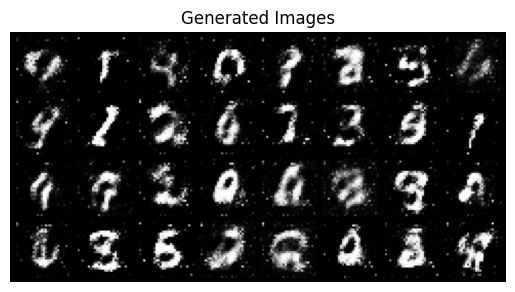

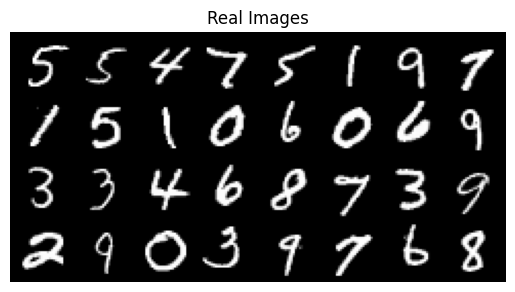

In [13]:
# Visualize the generated image at the end of the 50 epochs
import matplotlib.pyplot as plt

with torch.no_grad():
    fake = gen(fixed_noise).reshape(-1, 1, 28, 28)
    data = real.reshape(-1, 1, 28, 28)
    img_grid_fake = torchvision.utils.make_grid(fake, normalize=True)
    img_grid_real = torchvision.utils.make_grid(data, normalize=True)

    plt.imshow(img_grid_fake.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Generated Images")
    plt.show()
    plt.imshow(img_grid_real.permute(1, 2, 0))
    plt.axis("off")
    plt.title("Real Images")
    plt.show()